## SPOT method for paired image generation

In [3]:
import torch
import os
import torch.nn as nn
import numpy as np
#from sklearn import datasets
from torch.utils.data import DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.utils.data as torch_data
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import pickle
import tqdm
from PIL import Image

### Downloading datasets
#### 1) MNIST and MNISTM

In [53]:
# MNIST(https://pytorch.org/docs/stable/torchvision/datasets.html )
# tranforming PIL Images to tensor
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])])

mnist_train = Datasets.MNIST('./Datasets/', download=False, 
                                     train=True,
                                     transform = transform
                            )

mnist_test = Datasets.MNIST('./Datasets/', download=False, 
                                     train=False,
                                     transform = transform
                           )

# loading mnist train and test data
# (torch.Size([bath_size, 1, image_size, image_size]), torch.Size([batch_size])
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size,
                                          shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size_test,
                                         shuffle=True)

In [54]:
#MNISTM

# load MNIST-M images from pkl file
with open('./Datasets/mnistm_data.pkl', "rb") as f:
    mnist_m_data = pickle.load(f, encoding='bytes')
    
mnist_m_data_train = torch.cat([transform(Image.fromarray(mnist_m_data['train']['data'][i], mode='RGB')).reshape(1, 3, image_size, image_size)
                               for i in tqdm.tqdm_notebook(range(len(mnist_m_data['train']['data'])))], 0)

mnist_m_data_test = torch.cat([transform(Image.fromarray(mnist_m_data['test']['data'][i], mode='RGB')).reshape(1, 3, image_size, image_size)  
                               for i in tqdm.tqdm_notebook(range(len(mnist_m_data['test']['data'])))], 0)

mnist_m_label_train = torch.tensor(mnist_m_data['train']['labels'])
mnist_m_label_test = torch.tensor(mnist_m_data['test']['labels'])

/Users/nopigeon/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/nopigeon/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [55]:
class MNISTM(torch_data.Dataset):
    def __init__(self, X, y):
        super(MNISTM, self).__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [56]:
train_dset = MNISTM(mnist_m_data_train, mnist_m_label_train) 
test_dset = MNISTM(mnist_m_data_test, mnist_m_label_test) 

# (torch.Size([bath_size, 3, image_size, image_size]), torch.Size([batch_size])
mnistm_train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
mnistm_test_loader = DataLoader(test_dset, batch_size=batch_size_test, shuffle=False) 

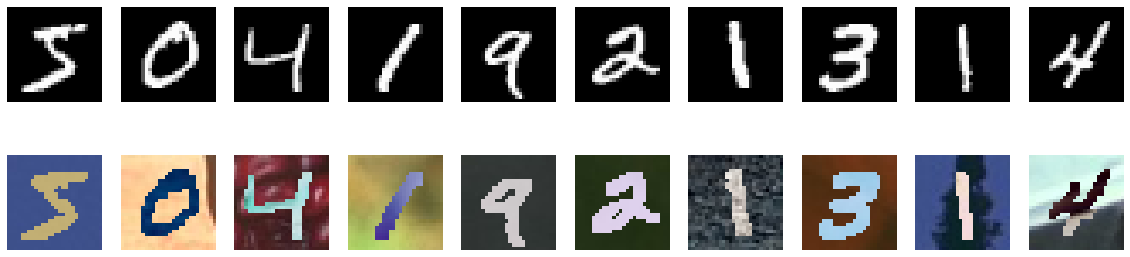

In [758]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
        ax[0, i].imshow(mnist_data_train.data[i].numpy().reshape(28, 28), cmap='gray')
        ax[1, i].imshow(mnist_m_data['train']['data'][i])
        ax[0, i].axis('off')
        ax[1, i].axis('off')

In [752]:
# это можно отдельным файлом генерировать
# Creating MNISTM dataset
# moderation of code by pumpikano (https://github.com/pumpikano/tf-dann/blob/master/create_mnistm.py)
import os
import pickle as pkl
import urllib.request
import tarfile
import skimage
import skimage.io

# create Datasets folder
# set download=True if file hasn't been downloaded
mnist_data_train = Datasets.MNIST('./Datasets/', download=False, 
                                     train=True,
                                     transform = transforms.Compose([
                                                                    transforms.Resize(image_size),
                                                                    transforms.ToTensor()
                                                                    ]))                                                         
mnist_data_test = Datasets.MNIST('./Datasets/', download=False, 
                                     train=False,
                                     transform = transforms.Compose([
                                                                    transforms.Resize(image_size),
                                                                    transforms.ToTensor()
                                                                    ]))                                                 

(mnist_train_data, mnist_train_labels) = (mnist_data_train.data.numpy(), mnist_data_train.targets.numpy())
(mnist_test_data, mnist_test_labels) = (mnist_data_test.data.numpy(), mnist_data_test.targets.numpy())

# checking or downloading background data
BST_PATH = './Datasets/BSR_bsds500.tgz'
url = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'

if os.path.isfile(BST_PATH):
    print('Backgrounds has been downloaded.')
else:
    print('Downloading..')
    urllib.request.urlretrieve(url, BST_PATH)

# retrieving background data
rand = np.random.RandomState(42)
background_data = []
f = tarfile.open(BST_PATH)

for name in f.getnames():
    if name.startswith('BSR/BSDS500/data/images/train/'):
        try:
            fp = f.extractfile(name)
            bg_img = skimage.io.imread(fp)
            background_data.append(bg_img)
        except:
            continue
            
if len(background_data) != 0:
    print('Backround data has been retrieved.')


def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)


def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)


def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):
    
        if i % 1000 == 0:
            print(f'Processing {i}/{X.shape[0]}...', end='\r')

        bg_img = rand.choice(background_data)

        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d

    return X_

print('Start of building trin and test sets...')
train_data = create_mnistm(mnist_train_data)
test_data = create_mnistm(mnist_test_data)
print('End of building sets.')

dataset = {'train': {
            'data': train_data,
            'labels': mnist_train_labels
         },
          'test': {
            'data': test_data,
            'labels': mnist_test_labels
          }}
# Save dataset as pickle
with open('./Datasets/mnistm_data.pkl', 'wb') as f:
        pkl.dump(dataset, f, pkl.HIGHEST_PROTOCOL)
        
if os.path.isfile('./Datasets/mnistm_data.pkl'):
    print('File with mnistm dataset has been saved.')

Backgrounds has been downloaded.
Backround data has been retrieved.
Start of building trin and test sets...
End of building sets.....
File with mnistm dataset has been saved.


#### 2) Photo-monet

In [ ]:
batch_size = 32
batch_size_test = 32
image_size = 16 

transform_monet = transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])

In [472]:
X = Datasets.ImageFolder('./Datasets/monet2photo/monet', transform=transform_monet)
Y = Datasets.ImageFolder('./Datasets/monet2photo/photo', transform=transform_monet)

X_loader = DataLoader(X, batch_size=batch_size, shuffle=True)
Y_loader = DataLoader(Y, batch_size=batch_size, shuffle=True)

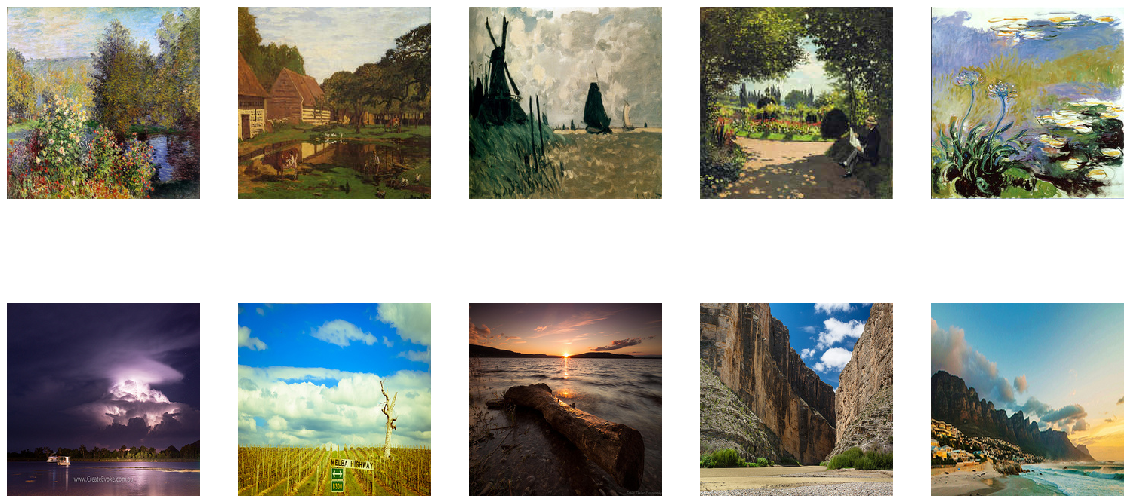

In [491]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
for i in range(5):
        ax[0, i].imshow(imageio.imread(X.imgs[i][0]))
        ax[1, i].imshow(imageio.imread(Y.imgs[i][0]))
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        
plt.show()

### Algorithm realization

In [49]:
# form Appendix.A.1(No-sharing Network)
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        assert latent_size == 100, 'length of Z should be 100'
        
        # for generators should be 4 hidden convolutional layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_size, 
                out_channels=512,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=512, 
                out_channels=256,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=256, 
                out_channels=128,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, 
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, 
                out_channels=3,
                kernel_size=2,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )
    #INPUT: Z in R^100,  N(0, I)
    def forward(self, z):
        # if isinstance(z.data, torch.cuda.FloatTensor)
        # output = nn.parallel.data_parallel(self.main, z, range(self.ngpu))
        output = self.deconv(z)
        return output
     
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=64,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True), # in the paper ReLU
            nn.Conv2d(
                in_channels=64, 
                out_channels=128,
                kernel_size=2,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=128, 
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=256, 
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=512, 
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False
            )
        )
    #INPUT: image x in R^(64x64x3) in mu or nu
    def forward(self, x):
        output = self.conv(x)
        output = output.mean(0)
        return output.view(1) 

In [57]:
# cost function for MNIST and MNISTM (adding knowledge about countour)

def c(x, y, channels=3):
    C1 = Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) 
    C2 = Tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    conv1 = nn.Conv2d(
        in_channels = channels, 
        out_channels = 1, 
        kernel_size=3, 
        bias=False)
    
    conv2 = nn.Conv2d(
        in_channels = channels, 
        out_channels = 1, 
        kernel_size = 3, 
        bias=False)
    
    conv1.weight.data[0, :, :, :] = C1
    conv2.weight.data[0, :, :, :] = C2
    
    conv1.weight.data.requires_grad = False
    conv2.weight.data.requires_grad = False
    
    return torch.norm(conv1(x) - conv1(y), p='fro') + torch.norm(conv2(x) - conv2(y), p='fro')

In [58]:
lr = 10**(-4)
eta = 10**(-3)
clamp_down = -0.01
clamp_up = 0.01
beta1 = 0.5
batch_size = 32
batch_size_test = 32
image_size = 32 
latent_size = 100 # Z
hidden_g = 4   # number of hidden layers for generators
hidden_d = 5   # number of hidden layers for discriminators
n_epoch = int(2*10**5)
lambda_iter = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

# function for first weights normalization for generators and discriminators
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Initialization of models, weights of models, inputs
Gx = Generator(latent_size)
Gy = Generator(latent_size)

lambda_x = Discriminator()
lambda_y = Discriminator()

Gx.apply(weights_init)
Gy.apply(weights_init)

lambda_x.apply(weights_init)
lambda_y.apply(weights_init)

Gx.to(device)
Gy.to(device)
lambda_x.to(device)
lambda_y.to(device)

#x_cpu = Tensor(batch_size, 1, image_size, image_size).to(device)
#y_cpu = Tensor(batch_size, 3, image_size, image_size).to(device)
#z = Tensor(batch_size, latent_size, 1, 1).to(device)
fixed_z = torch.FloatTensor(batch_size, latent_size, 1, 1).normal_(0, 1).to(device)
one = Tensor([1]).to(device)
minus_one = Tensor([-1]).to(device)
    
# Optimizers
parameters_lambda = list(lambda_x.parameters()) + list(lambda_y.parameters())
parameters_G = list(Gx.parameters()) + list(Gy.parameters())

optimizer_lambda = torch.optim.Adam(parameters_lambda, lr=lr, betas=(beta1, 0.999))
optimizer_G = torch.optim.Adam(parameters_G, lr=lr, betas=(beta1, 0.999))

In [ ]:
for epoch in range(0, n_epoch):
    data_iter_x = iter(mnist_test_loader)
    data_iter_y = iter(mnistm_test_loader)
    i = 0
    # for i, ((x, _), (y, _)) in enumerate(zip(mnist_test_loader, mnistm_test_loader)):
    while i < len(mnist_test_loader) - 1:

       # x_cpu = x
       # y_cpu = y

        # update lambda parameters
        for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
            param_x.requires_grad = True
            param_y.requires_grad = True

        j = 0
        while j < 3 and i < len(mnist_test_loader) - 1: 

                j += 1
                i += 1

                x, _ = data_iter_x.next()
                y, _ = data_iter_y.next()

                x_cpu = x
                y_cpu = y
                if x.shape[0] != y.shape[0]:
                        continue
            #clamp parameters 
                for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
                        param_x.data.clamp_(-0.1, 0.1)
                        param_y.data.clamp_(-0.1, 0.1)

                z = Tensor(batch_size, latent_size, 1, 1).normal_(0, 1)#.to(device)
                x = x.expand_as(y)
                lambda_x.zero_grad()
                lambda_y.zero_grad()

                real_lambda_x = lambda_x(x)
                real_lambda_y = lambda_y(y)

                real_lambda_x.backward(one)
                real_lambda_y.backward(one)
            #print(Gx(z).data.shape)
                fake_lambda_x = lambda_x(Gx(z).data)
                fake_lambda_y = lambda_y(Gy(z).data)

                fake_lambda_x.backward(minus_one)
                fake_lambda_y.backward(minus_one)
                err_lambda = real_lambda_x + real_lambda_y - fake_lambda_y - fake_lambda_x

                optimizer_lambda.step()

        # update generators parameters
        for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
            param_x.requires_grad = False
            param_y.requires_grad = False

        Gx.zero_grad()
        Gy.zero_grad()

        z = Tensor(batch_size, latent_size, 1, 1).normal_(0, 1)#.to(device)
        fake_x = Gx(z)
        fake_y = Gy(z)
        err_G = lambda_x(fake_x) + lambda_y(fake_y) + eta*c(fake_x, fake_y)
        err_G.backward(one)

        optimizer_G.step()

    if epoch % 5 == 0:
        logging.info('Epoch {}/{} || Loss_lambda: {:.4f} || Loss_G {:.4f}'.format(epoch, n_epoch, err_lambda.data[0], err_G.data[0]))

        x_cpu = x_cpu.mul(0.5).add(0.5)
        y_cpu = y_cpu.mul(0.5).add(0.5)
        fake_x = Gx(fixed_z).data.mul(0.5).add(0.5)
        fake_y = Gy(fixed_z).data.mul(0.5).add(0.5)

        save_image(x_cpu, './{}/real_samplex.png'.format(0))
        save_image(y_cpu, './{}/real_sampley.png'.format(0))
        save_image(fake_x, './{}/fake_samplex_{}.png'.format(0, epoch))
        save_image(fake_y, './{}/fake_samplex{}.png'.format(0, epoch))

        # do checkpointing
        torch.save(Gx.state_dict(), './0/Gx.pth')
        torch.save(Gy.state_dict(), './0/Gy.pth')
        torch.save(lambda_x.state_dict(), './0/lambda_x.pth')
        torch.save(lambda_y.state_dict(), './0/lambda_y.pth')

### Gaussian learning

#### 1) Generatiron of samples

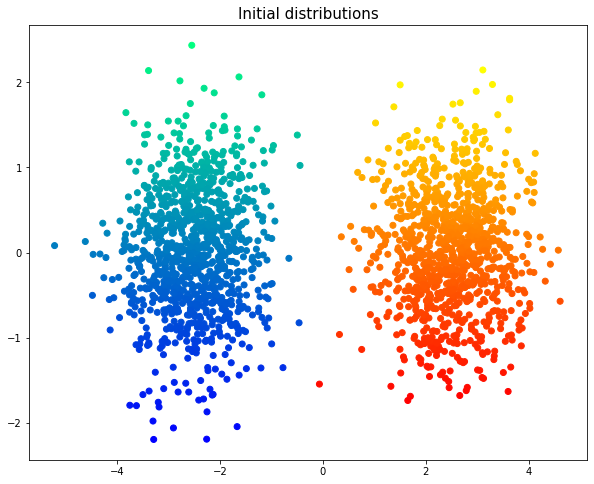

In [34]:
torch.manual_seed(42)
mean1 = torch.tensor([-2.5, 0])
mean2 = torch.tensor([2.5, 0])

cov1 = 0.5*torch.eye(2)
cov2 = 0.5*torch.eye(2)

m1 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mean1, covariance_matrix=cov1)
m2 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mean2, covariance_matrix=cov2)

gaus1 = m1.sample([1000])
gaus2 = m2.sample([1000])

plt.figure(figsize=(10, 8))
plt.scatter(gaus1[:, 0], gaus1[:, 1], c=gaus1[:, 1], cmap='winter')
plt.scatter(gaus2[:, 0], gaus2[:, 1], c=gaus2[:, 1], cmap='autumn')
plt.title('Initial distributions', fontsize=15)
plt.savefig('gaus_initial')
plt.show()

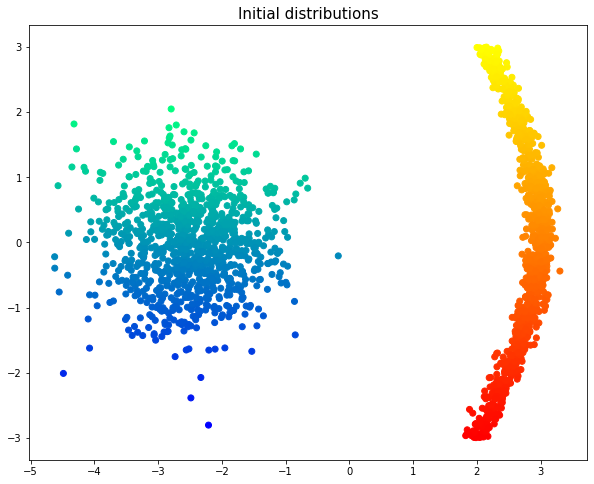

In [36]:
torch.manual_seed(42)
mean1 = np.array([-2.5, 0])

cov1 = 0.5*np.eye(2)

dist1 = np.random.multivariate_normal(mean1, cov1, 1000)
y1 = np.random.uniform(0, 3, 1000)
y2 = np.random.normal(2, 0.1, 1000)
dist2 = np.array([np.sin(y1) + y2, 2*y1 -3]).T

dist1 = torch.FloatTensor(dist1)
dist2 = torch.FloatTensor(dist2)

plt.figure(figsize=(10, 8))
plt.scatter(dist1[:, 0], dist1[:, 1], c=dist1[:, 1], cmap='winter')
plt.scatter(dist2[:, 0], dist2[:, 1], c=dist2[:, 1], cmap='autumn')
plt.title('Initial distributions', fontsize=15)
plt.savefig('distributions_2')
plt.show()

### 2) Algorithm

In [5]:
lr = 10**(-4)
hidden_size = 32
latent_size = 2
batch_size = 100
beta1=0.5
n_epoch = int(10**5)
lambda_iter = 2
eta = 1e-4

gaus1 = m1.sample([10000])
gaus2 = m2.sample([10000])

In [6]:
class Gaussian(torch_data.Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
device = 'cpu'

In [7]:
gaus1_loader = DataLoader(Gaussian(gaus1), shuffle=True, batch_size=batch_size)
gaus2_loader = DataLoader(Gaussian(gaus2), shuffle=True, batch_size=batch_size)

In [11]:
# cost function 2-norm of given vectors difference
def c(x, y):
    return torch.norm(x - y)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
            
        self.net = nn.Sequential(
                nn.Linear(2, hidden_size),
                #nn.BatchNorm(hidden_size),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(hidden_size, hidden_size),
                #nn.BatchNorm(hidden_size),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(hidden_size, hidden_size),
                #nn.BatchNorm(hidden_size),
                nn.LeakyReLU(0.2, inplace=True),               
                nn.Linear(hidden_size, 2),
                #nn.BatchNorm(2)
            )
    def forward(self, x):
        output = self.net(x)
        return output
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
            
        self.net = nn.Sequential(
                nn.Linear(2, hidden_size),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(hidden_size, 1)
            )
    def forward(self, x):
        output = self.net(x)
        output = output.mean(0)
        return output.view(1)

In [12]:
fixed_z = torch.FloatTensor(batch_size, 2).normal_(0, 1).to(device)
fake_x =[]
fake_y = []

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

# function for first weights normalization for generators and discriminators
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Initialization of models, weights of models, inputs
Gx = Generator()
Gy = Generator()

lambda_x = Discriminator()
lambda_y = Discriminator()

Gx.apply(weights_init)
Gy.apply(weights_init)

lambda_x.apply(weights_init)
lambda_y.apply(weights_init)

Gx.to(device)
Gy.to(device)
lambda_x.to(device)
lambda_y.to(device)

one = Tensor([1]).to(device)
minus_one = Tensor([-1]).to(device)
    
# Optimizers
parameters_lambda = list(lambda_x.parameters()) + list(lambda_y.parameters())
parameters_G = list(Gx.parameters()) + list(Gy.parameters())

optimizer_lambda = torch.optim.Adam(parameters_lambda, lr=lr, betas=(beta1, 0.999))
optimizer_G = torch.optim.Adam(parameters_G, lr=lr, betas=(beta1, 0.999))

In [15]:
# Training
for epoch in range(n_epoch):
    for i, (x, y) in enumerate(zip(gaus1_loader, gaus2_loader)):
        # if batch sizes are not equal continue
        if x.shape[0] != y.shape[0]:
            continue
            
        x_cpu = x
        y_cpu = y
        
        x.to(device)
        y.to(device)
        
        # update lambda parameters
        for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
            param_x.requires_grad = True
            param_y.requires_grad = True

        for j in range(lambda_iter):

            for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
                param_x.data.clamp_(-0.1, 0.1)
                param_y.data.clamp_(-0.1, 0.1)
                
            z = Tensor(batch_size, 2).normal_(0, 1).to(device)
            x = x.expand_as(y)

            lambda_x.zero_grad()
            lambda_y.zero_grad()

            real_lambda_x = lambda_x(x)
            real_lambda_y = lambda_y(y)
            
            real_lambda_x.backward(one)
            real_lambda_y.backward(one)

            fake_lambda_x = lambda_x(Gx(z).data)
            fake_lambda_y = lambda_y(Gy(z).data)
            
            fake_lambda_x.backward(minus_one)
            fake_lambda_y.backward(minus_one)
            err_lambda = real_lambda_x + real_lambda_y - fake_lambda_y - fake_lambda_x
            
            optimizer_lambda.step()
 
        # update generators parameters
        for param_x, param_y in zip(lambda_x.parameters(), lambda_y.parameters()):
            param_x.requires_grad = False
            param_y.requires_grad = False

        Gx.zero_grad()
        Gy.zero_grad()
        
        z = Tensor(batch_size, 2).normal_(0, 1).to(device)
        fake_x = Gx(z)
        fake_y = Gy(z)
        
        err_G = lambda_x(fake_x) + lambda_y(fake_y) + eta*c(fake_x, fake_y)
        err_G.backward(one)
        
        optimizer_G.step()

    if epoch % 500 == 0:
        print('Epoch {}/{} || Loss_lambda: {:.7f} || Loss_G {:.7f}'.format(epoch, n_epoch, err_lambda.data[0], err_G.data[0]))

Epoch 0/100000 || Loss_lambda: -0.3432345 || Loss_G 0.3189731
Epoch 500/100000 || Loss_lambda: 0.0130963 || Loss_G 0.4117712
Epoch 1000/100000 || Loss_lambda: -0.0500030 || Loss_G 0.5028054
Epoch 1500/100000 || Loss_lambda: -0.0180921 || Loss_G 0.3691860
Epoch 2000/100000 || Loss_lambda: 0.0040706 || Loss_G 0.3861254
Epoch 2500/100000 || Loss_lambda: -0.0172247 || Loss_G 0.7560351
Epoch 3000/100000 || Loss_lambda: 0.0555736 || Loss_G -0.1476424
Epoch 3500/100000 || Loss_lambda: -0.0505502 || Loss_G 0.0926341
Epoch 4000/100000 || Loss_lambda: -0.0019488 || Loss_G 0.1472251
Epoch 4500/100000 || Loss_lambda: 0.0164728 || Loss_G -0.0652099
Epoch 5000/100000 || Loss_lambda: -0.0325668 || Loss_G -0.1946788
Epoch 5500/100000 || Loss_lambda: 0.0193019 || Loss_G 0.2637183
Epoch 6000/100000 || Loss_lambda: -0.0009798 || Loss_G 0.0355157
Epoch 6500/100000 || Loss_lambda: -0.0329685 || Loss_G -0.1645955
Epoch 7000/100000 || Loss_lambda: -0.0257795 || Loss_G 0.6806505
Epoch 7500/100000 || Loss_lamb

KeyboardInterrupt: 